In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
data = pd.read_csv('/Users/javadzabihi/Downloads/IS698 project/Reviews.csv')

In [4]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [7]:
data.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [4]:
# "Positive" : 1, "Negative": 0
data['Sentiment'] = data['Score'].apply(lambda score: 1 if score > 3 else 0)

In [9]:
data.Sentiment.value_counts()

1    443777
0    124677
Name: Sentiment, dtype: int64

In [7]:
### I'm choosing a very small subset of the dataset to speed up the run
X = data.loc[:500,'Text']
y = data.loc[:500,'Sentiment']

In [5]:
from nltk.stem.porter import PorterStemmer


# One way to split the text corpora into individual elements is
# to split them into individual words by splitting the cleaned documents 
# at its whitespace characters.

def tokenizer(text):
    return text.split()


# A useful technique in the context of tokenization is word stemming, which
# is the process of transforming a word into its root form. 
# It allows us to map related words to the same stem.

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [6]:
import nltk

nltk.download('stopwords')

# Removing stop-words can be useful if we are working with raw or 
# normalized term frequencies rather than tf-idfs, which are already 
# downweighting frequently occurring words.

from nltk.corpus import stopwords

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javadzabihi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

# Sentiment analysis

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


###### TfidfVectorizer combines the task of CountVectorizer and TfidfTransformer.
# from sklearn.feature_extraction.text import CountVectorizer
# count = CountVectorizer()
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf = TfidfTransformer(use_idf=True, 
#                         norm='l2', 
#                         smooth_idf=True)
# tfidf.fit_transform(count.fit_transform(text)).toarray()

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

# Using a GridSearchCV object to find the optimal set of parameters 
# for our logistic regression model.

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [10]:
gs_lr_tfidf.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

# The "best_score_" attribute returns the average score over the k-folds of the best model.
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   40.0s finished


Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x1a1fc35488>, 'vect__use_idf': False} 
CV Accuracy: 0.836
Test Accuracy: 0.867


In [16]:
# The best grid search results using Porter stemming instead of the regular tokenizer, 
# no stop-word library, and a logistic regression classifier 
# that uses L2-regularization with the regularization strength C of 10.0
# based of raw term frequencies.
# regularization strengths is defined by the inverse-regularization parameter C.


# Recommendation Engine

In [3]:
data_recommender = data.loc[:, ['ProductId', 'UserId', 'Score', 'Time']]
data_recommender.head(2)

,ProductId,UserId,Score,Time
0,B001E4KFG0,A3SGXH7AUHU8GW,5,1303862400
1,B00813GRG4,A1D87F6ZCVE5NK,1,1346976000


In [12]:
# Calculation the number of unique users and products

n_users = data.UserId.unique().shape[0]   # 256059
n_products = data.ProductId.unique().shape[0] # 74258

In [13]:
# creating a dataframe with the average rating for each product

ratings = pd.DataFrame(data_recommender.groupby('ProductId')['Score'].mean())
ratings.head()

,Score
ProductId,
0006641040,4.351351
141278509X,5.000000
2734888454,3.500000
2841233731,5.000000
7310172001,4.751445


In [14]:
# Adding the number of ratings for each product to the ratings dataframe

ratings['number_of_ratings'] = data_recommender.groupby('ProductId')['Score'].count()
ratings.head()

,Score,number_of_ratings
ProductId,,
0006641040,4.351351,37
141278509X,5.000000,1
2734888454,3.500000,2
2841233731,5.000000,1
7310172001,4.751445,173


In [15]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,Score,number_of_ratings
ProductId,,
B007JFMH8M,4.582694,913
B0026RQTGE,4.588608,632
B002QWHJOU,4.588608,632
B002QWP89S,4.588608,632
B002QWP8H0,4.588608,632
B003B3OOPA,4.739968,623
B001EO5Q64,4.746032,567
B0026KPDG8,4.310284,564
B000VK8AVK,4.310284,564


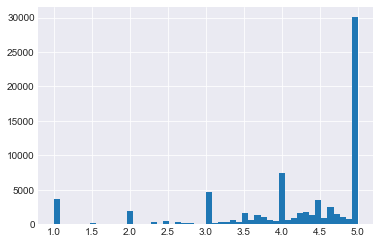

In [24]:
ratings['Score'].hist(bins=50)

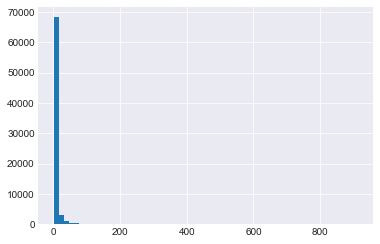

In [25]:
ratings['number_of_ratings'].hist(bins=60)

/Applications/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


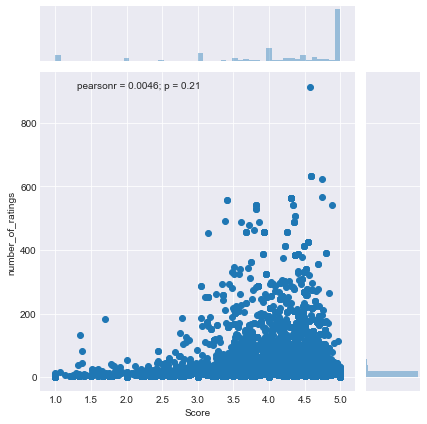

In [26]:
sns.jointplot(x='Score', y='number_of_ratings', data=ratings)

# Collaborative filtering

In [44]:
data_recommender.head()

,ProductId,UserId,Score,Time
0,B001E4KFG0,A3SGXH7AUHU8GW,5,1303862400
1,B00813GRG4,A1D87F6ZCVE5NK,1,1346976000
2,B000LQOCH0,ABXLMWJIXXAIN,4,1219017600
3,B000UA0QIQ,A395BORC6FGVXV,2,1307923200
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,1350777600


In [45]:
X_rec = data_recommender.loc[:1000,['ProductId', 'UserId', 'Score']]
y_rec = data_recommender.loc[:1000,'UserId']

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec, test_size=0.2, random_state=42)

In [42]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [43]:
# Defining the baseline model to always return 3.
def baseline(user_id, product_id):
    return 3.0

In [49]:
def score(cf_model):
    
    # Constructing a list of user-product tuples from the testing dataset
    id_pairs = zip(X_test['UserId'], X_test['ProductId'] )
    
    # Predicting the score for every user-product tuple
    y_pred = np.array([cf_model(user, product) for (user, product) in id_pairs])
    
    # Extracting the actual ratings given by the users in the testing dataset
    y_true = np.array(X_test['Score'])
    
    # Returning the rsme score
    return rmse(y_true, y_pred)



In [50]:
# We will try to build a recommender system with a score lower than our baseline model.
score(baseline)

1.7661831686081222

In [64]:
# Building a ratings matrix where each row represents a user,
# each column represents a product, and the values are the scores.
# Then the value in the ith row and jth column will denote the score
# given by user i to product j.

r_matrix = X_train.pivot_table(index = 'UserId', columns = 'ProductId', values = 'Score')

r_matrix.head(2)

ProductId,B0002567IW,B00029XIZI,B0002XIB2Y,B00061KYVI,B00067AD4U,B0007NG568,B0007NG56I,B0009XLVG0,B0009XLVGA,B000C21OOM,...,B007TFONH0,B007ZENY5W,B00813GRG4,B0081XN2HQ,B00821UN4M,B0087HW5E2,B0089PI9OC,B008BEGP9W,B0093NIWVO,B009HINRX8
UserId,,,,,,,,,,,,,,,,,,,,,
A104Y49ZQ4CYJ2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A108P30XVUFKXY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# User based collaborative filtering using mean of scores
# Assigning equal wights to all users when calculating the score

def cf_user_mean(UserId, ProductId):
    # Check if product exists in r_matrix
    if ProductId in r_matrix:
        # Compute the mean of all the scores given to that product
        mean_rating = r_matrix[ProductId].mean()
        
    else:
        # Default to a rating of 3.0 in the absence of any information
        mean_rating = 3.0
        
    return mean_rating



In [62]:
# RMSE for the mean model
# the score is better than the baseline model
score(cf_user_mean)

1.3446551627203842

In [63]:
# Weighted mean
# It's better to give a higher weight to those users whose scores are similar
# to the user in question.
# Using cosine similarity function
# Cosine similarity function does not work with NaN values.
# Therfore we need to convert all missing values in the r_matrix to zero.

r_matrix_dummy = r_matrix.copy().fillna(0)

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy)

cosine_sim = pd.DataFrame(cosine_sim, index = r_matrix.index, columns = r_matrix.index)

cosine_sim.head(2)

UserId,A104Y49ZQ4CYJ2,A108P30XVUFKXY,A10EHUTGNC4BGP,A11LJJL1SOH6W0,A11QUNPSCNHY62,A11UPZ6LI1UJZY,A11VPI6WLMQ2ZQ,A12OF4IM7A8YS,A12T0F58OKHCIW,A137DV4YVGWDCR,...,AYAU6OMJ81Q7Z,AYB4ELCS5AM8P,AYMV2T86WIXVD,AYSEXV27DPQ3E,AYZZSRYAIXNOS,AZ2NEHE8TNRUW,AZ3FPU1QSFBC6,AZ7289G0ILRFF,AZLONLC8OZPEC,AZOF9E17RGZH8
UserId,,,,,,,,,,,,,,,,,,,,,
A104Y49ZQ4CYJ2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A108P30XVUFKXY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# User based collaborative filtering using weighted mean ratings
def cf_user_wmean(UserId, ProductId):
    
    # check if product exists in r_matrix
    if ProductId in r_matrix:
        
        # Get the similarity scores for the user in question with every other user
        sim_scores = cosine_sim[UserId]
        
        # Get the user ratings for the product in question
        p_ratings = r_matrix[ProductId]
        
        # Extract the indices with NaN value in the p_ratings series
        idx = p_ratings[p_ratings.isnull()].index
        
        # Drop the NaN values from p_ratings series
        p_ratings = p_ratings.dropna()
        
        # Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        # Compute the final weighted mean
        wmean_rating = np.dot(sim_scores, p_ratings) / sim_scores.sum()
        
    else:
        
        # Default to a rating of 3.0 in the absence of any information
        wmean_rating = 3.0
        
    return wmean_rating
        



In [4]:
data_surprise = data_recommender.loc[:1000 , ['UserId', 'ProductId', 'Score']]

In [80]:
data_surprise.head()

,UserId,ProductId,Score
0,A3SGXH7AUHU8GW,B001E4KFG0,5
1,A1D87F6ZCVE5NK,B00813GRG4,1
2,ABXLMWJIXXAIN,B000LQOCH0,4
3,A395BORC6FGVXV,B000UA0QIQ,2
4,A1UQRSCLF8GW1T,B006K2ZZ7K,5


In [5]:


from surprise import Reader, Dataset, KNNBasic, evaluate

reader = Reader()

dataset = Dataset.load_from_df(data_surprise, reader)

knn = KNNBasic()

evaluate(knn, dataset, measures = ['RMSE'])

Evaluating RMSE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2962
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3730
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2698
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3641
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3205
------------
------------
Mean RMSE: 1.3247
------------
------------


/Applications/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/Applications/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


CaseInsensitiveDefaultDict(list,
                           {'rmse': [1.2961829095738864,
                             1.3730175084801437,
                             1.2697566873121826,
                             1.3640878290396823,
                             1.3204518363821316]})

In [10]:
from surprise import SVD

svd = SVD()

evaluate(svd, dataset, measures = ['RMSE'])


/Applications/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/Applications/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 1.2863
------------
Fold 2
RMSE: 1.3369
------------
Fold 3
RMSE: 1.2642
------------
Fold 4
RMSE: 1.3247
------------
Fold 5
RMSE: 1.3083
------------
------------
Mean RMSE: 1.3041
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [1.2862587924408273,
                             1.3369039924598491,
                             1.2641723896415604,
                             1.3247314272681825,
                             1.308300007750743]})